In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [2]:
stock = "META"

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [3]:
stock_data = yf.download(stock, start, end)
stock_data.astype("double")
stock_data.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-28,268.739990,277.299988,265.660004,277.000000,277.000000,23299700
2020-12-29,276.950012,280.510010,276.279999,276.779999,276.779999,16383000
2020-12-30,277.950012,278.079987,271.709991,271.869995,271.869995,11803800


In [4]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,254.120053,257.924629,250.734233,254.318029,254.318029,2.616223e+07
std,78.163035,78.508849,77.608584,78.139927,78.139927,1.783572e+07
min,90.080002,90.459999,88.089996,88.910004,88.910004,5.467500e+06
25%,186.295006,190.614998,182.732498,184.952499,184.952499,1.655310e+07
50%,270.659988,274.994995,268.164993,271.630005,271.630005,2.190510e+07
75%,323.350006,327.865005,319.362488,324.162506,324.162506,2.997925e+07
max,381.679993,384.329987,378.809998,382.179993,382.179993,2.323166e+08


In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-12-28 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


#### Creating train/test validation split:
An LSTM time series model looks back on previous historical time range data to predict future data to come in the same timeseries. So in our case we will have our "X" input be a sequence of historical data (e.g. Open, High, Low, Close, Adj Close, Volume over the last 60 days) and our "y" input be the price the following day/s we are trying to predict (e.g. stock price on the 61st day).

In [6]:
num_days = 60
train_size = 0.8
raw_stock_data = stock_data.values
formatted_stock_data = []

for i in range(len(raw_stock_data)-num_days):
    formatted_stock_data.append(raw_stock_data[i: i+num_days])

train = np.array(formatted_stock_data[:int(len(formatted_stock_data)*train_size)])
test = np.array(formatted_stock_data[int(len(formatted_stock_data)*train_size):])

print(f"train shape = {train.shape}")
print(f"test shape = {test.shape}")

train shape = (556, 60, 6)
test shape = (140, 60, 6)


In [7]:
x_train = torch.from_numpy(train[:,:-1,:]).to(torch.float32)
y_train = torch.from_numpy(train[:,-1,:3:4]).to(torch.float32)

x_test = torch.from_numpy(test[:,:-1,:]).to(torch.float32)
y_test = torch.from_numpy(test[:,-1,:3:4]).to(torch.float32)

print(f"x_train shape = {x_train.shape}")
print(f"y_train shape = {y_train.shape}")
print(f"x_test shape = {x_test.shape}")
print(f"y_test shape = {y_test.shape}")

x_train shape = torch.Size([556, 59, 6])
y_train shape = torch.Size([556, 1])
x_test shape = torch.Size([140, 59, 6])
y_test shape = torch.Size([140, 1])


In [8]:
input_size = 6
hidden_size = 32
num_layers = 2
batch_first = True
bias = True
dropout = 0

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first, bias, dropout):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first, bias, dropout)
        self.out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.out(x[:, -1, :])
        return x


In [23]:
model = LSTM(input_size, hidden_size, num_layers, batch_first, bias, dropout)
x_train = x_train.to(torch.float32)

loss_foo = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [27]:
epochs = 101
losses = []

for i in range(epochs):
    # Forward pass
    y_train_pred = model.forward(x_train.to(torch.float32))

    # Measure loss
    loss = loss_foo(y_train_pred, y_train)
    losses.append(loss.item())

    # Print every 10 epochs
    if i % 10 == 0:
        print(f"Epoch = {i} and RMSE = {loss}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch = 0 and RMSE = 9798.8896484375
Epoch = 10 and RMSE = 9313.19140625
Epoch = 20 and RMSE = 8907.80859375
Epoch = 30 and RMSE = 8571.4287109375
Epoch = 40 and RMSE = 8293.9482421875
Epoch = 50 and RMSE = 8066.40283203125
Epoch = 60 and RMSE = 7880.91748046875
Epoch = 70 and RMSE = 7730.61767578125
Epoch = 80 and RMSE = 7609.56201171875
Epoch = 90 and RMSE = 7512.6416015625
Epoch = 100 and RMSE = 7435.5126953125
Epoch = 110 and RMSE = 7374.5029296875
Epoch = 120 and RMSE = 7326.53076171875
Epoch = 130 and RMSE = 7289.03955078125
Epoch = 140 and RMSE = 7259.91455078125
Epoch = 150 and RMSE = 7237.4228515625
Epoch = 160 and RMSE = 7220.1591796875
Epoch = 170 and RMSE = 7206.98828125
Epoch = 180 and RMSE = 7196.9990234375
Epoch = 190 and RMSE = 7189.46875


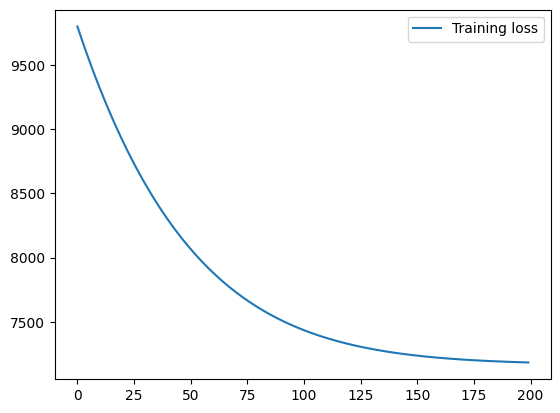

In [28]:
plt.plot(range(epochs), losses, label="Training loss")
plt.legend()
plt.show()

In [31]:
y_test_pred = model(x_test)

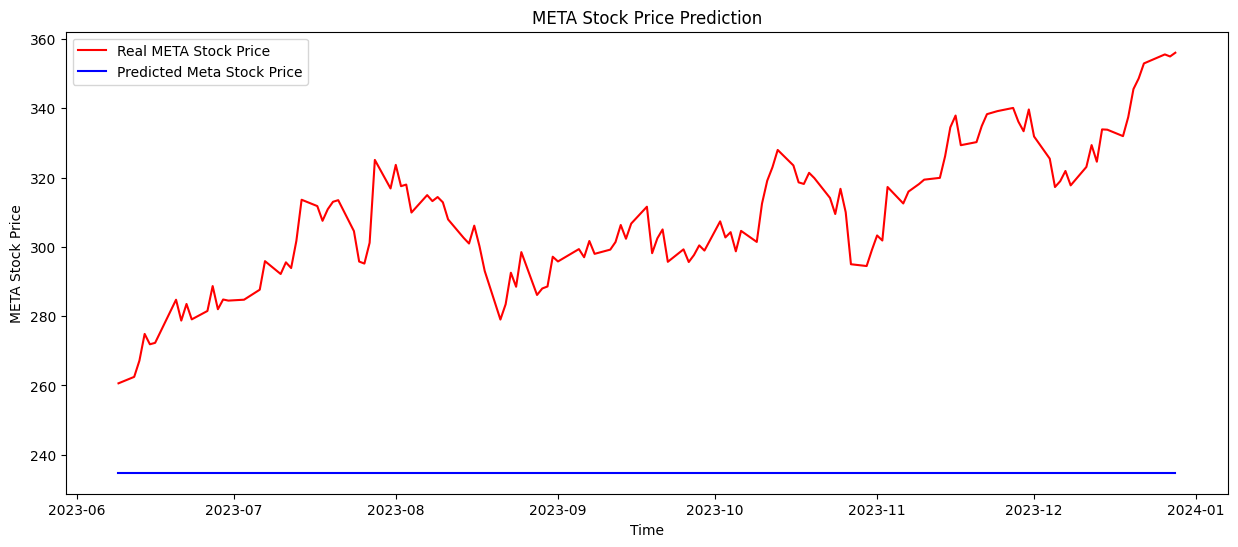

In [33]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(stock_data[len(stock_data)-len(y_test):].index, y_test.detach().numpy(), color = 'red', label = 'Real META Stock Price')
axes.plot(stock_data[len(stock_data)-len(y_test):].index, y_test_pred.detach().numpy(), color = 'blue', label = 'Predicted Meta Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('META Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('META Stock Price')
plt.legend()
plt.show()